#### 垃圾回收

* 引用
    - 在函数调用发生的时候，会产生额外的两次引用，一次来自函数栈，另一个是函数参数
* 内存泄漏
    - 程序本身没有设计好，导致程序未能释放已不再使用的内存
    - 意味着代码在分配了某段内存后，因为设计错误，失去了对这段内存的控制，从而造成了内存的浪费
* 回收机制
    - 当这个对象的引用计数（指针数）为 0 的时候，说明这个对象永不可达，自然它也就成为了垃圾，需要被回收
    - 手动回收：先调用 del a 来删除对象的引用；然后强制调用 gc.collect()
* 标记清除算法（mark-sweep）:先用图论来理解不可达的概念。对于一个有向图，如果从一个节点出发进行遍历，并标记其经过的所有节点；那么，在遍历结束后，所有没有被标记的节点，我们就称之为不可达节点。显而易见，这些节点的存在是没有任何意义的，自然的，需要对它们进行垃圾回收.每次都遍历全图，对于 Python 而言是一种巨大的性能浪费。所以，在 Python 的垃圾回收实现中，mark-sweep 使用双向链表维护了一个数据结构，并且只考虑容器类的对象（只有容器类对象才有可能产生循环引用）
* 分代收集（generational）:Python 将所有对象分为三代。刚刚创立的对象是第 0 代；经过一次垃圾回收后，依然存在的对象，便会依次从上一代挪到下一代。而每一代启动自动垃圾回收的阈值，则是可以单独指定的。当垃圾回收器中新增对象减去删除对象达到相应的阈值时，就会对这一代对象启动垃圾回收
    - 基于的思想是，新生的对象更有可能被垃圾回收，而存活更久的对象也有更高的概率继续存活。因此，通过这种做法，可以节约不少计算量，从而提高 Python 的性能

In [1]:
import os
import psutil

# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))

In [11]:
def func():
    show_memory_info('initial')
#     global a
    a = [i for i in range(10000000)]
    show_memory_info('after a created')

func()
show_memory_info('finished')

initial memory used: 472.57421875 MB
after a created memory used: 857.99609375 MB
finished memory used: 472.82421875 MB


In [2]:
# 循环引用：两个对象互相引用，并且不再被别的对象所引用
import gc
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    b = [i for i in range(10000000)]
    show_memory_info('after a, b created')
    a.append(b)
    b.append(a)

func()
gc.collect()
show_memory_info('finished')

initial memory used: 45.67578125 MB
after a, b created memory used: 819.0546875 MB
finished memory used: 46.96875 MB


#### 调试内存泄漏

* [objgraph](https://mg.pov.lt/objgraph/):一个非常好用的可视化引用关系的包
    - show_refs():生成清晰的引用关系图
    - show_backrefs():这个 API 有很多有用的参数，比如层数限制（max_depth）、宽度限制（too_many）、输出格式控制（filename output）、节点过滤（filter, extra_ignore）等

[1, 2, 3, [4, 5, 6, [...]]]
[4, 5, 6, [1, 2, 3, [...]]]


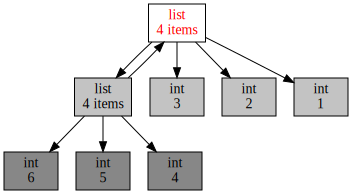

In [7]:

import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)
# print(a)
# print(b)
objgraph.show_refs([a])

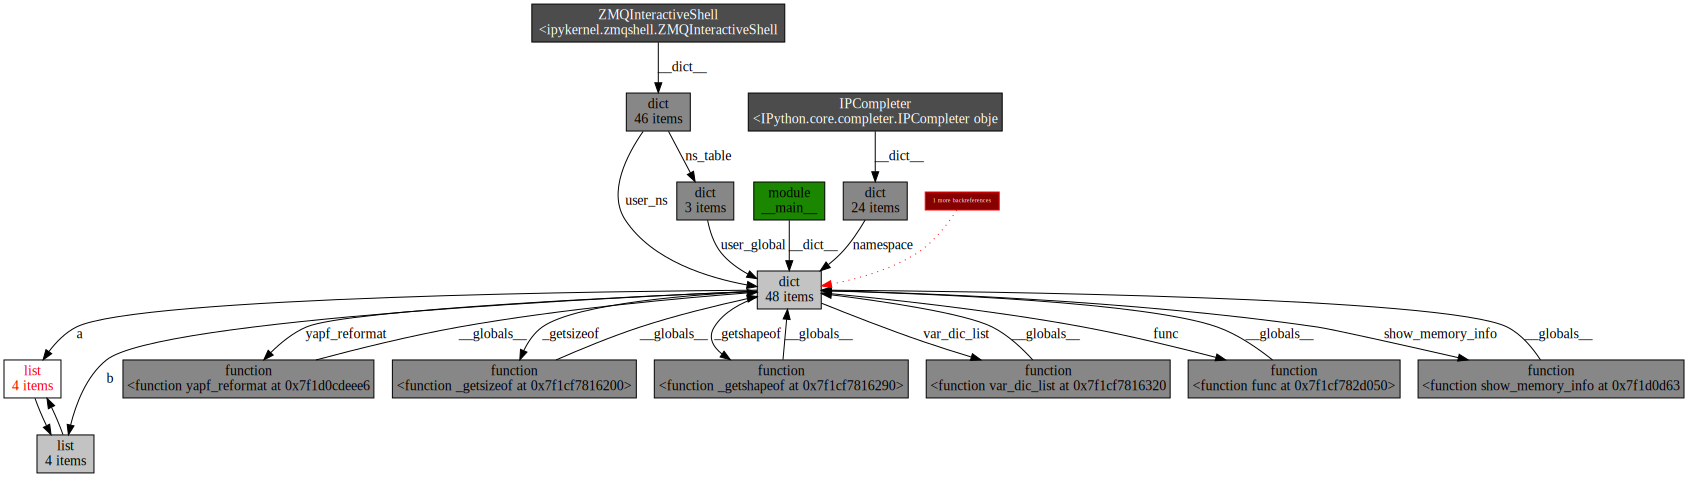

In [6]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_backrefs([a])